Добро пожаловать на хакатон по машинному обучению!

Разрабатываем скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого:
1. Проанализировать данные, которые есть "на руках".
2. Провести EDA и Feature Engeniring.
2. Определить значимые параметры заемщика.
3. запустить нашу модель и тд

# Go-go!

In [2]:
#Сперва, конечно, подключаем нужные библиотеки
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

Вынесем блок с функциями

In [30]:
#функция для создания boxPlot по набору колонок
def get_boxplot(column):
    #на вход наименование колоноки, в ответе боКсплоты
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=column, 
                data=data[data.Train == 1].loc[data[data.Train == 1].loc[:, column].isin(data[data.Train == 1].loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

#создание cat_plot
def get_catplot(column):
  g = sns.catplot("default", col=column, col_wrap=7,
                data=data[data.Train == 1],
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
  #fig.suptitle('sf')
  plt.show()

#создание displot для числовых переменных
def get_displot(column):
  plt.figure()
  sns.distplot(data[data.Train == 1][column], kde = False, rug=False)
  plt.title(i)
  plt.show()


In [4]:
#работаю в collab, поэтому модуль для загрузки данных
from google.colab import files
upload = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [5]:
#блок для kagle, куда потом переносить решение
#data_directory = '/kaggle/input/sf-dst-scoring/'
#df_train = pd.read_csv(data_directory+'train.csv')
#df_test = pd.read_csv(data_directory+'test.csv')

In [11]:
#Читаем данные, заодно смотрим что там творится
df_train = pd.read_csv("train.csv", sep=',')
df_test = pd.read_csv("test.csv", sep=',')
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


*   client_id 	идентификатор клиента
*   app_date  - дата подачи заявки
*   education 	уровень образования
*   sex 	пол заёмщика
*   age 	возраст заёмщика
*   car 	флаг наличия автомобиля
*   car_type 	флаг автомобиля-иномарки
*   decline_app_cnt 	количество отказанных прошлых заявок
*   good_work 	флаг наличия «хорошей» работы
*   score_bki некий скор из БКИ(Бюро Кредитной Истории)
*   bki_request_cnt 	количество запросов в БКИ
*   region_rating - рейтинг региона
*   home_address 	категоризатор домашнего адреса
*   work_address 	категоризатор рабочего адреса
*   income 	доход заёмщика
*   sna - связь заемщика с клиентами банка
*   first_time - давность наличия информации о заемщике
*   foreign_passport 	наличие загранпаспорта
*   default - шанс дефолта по кредиту 

In [13]:
#разделим колонки по типам, так будет проще строить графики
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']
time_cols = ['app_date']

In [12]:
df_train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [14]:
df_train['Train'] = 1 # отметим где фрейм для тренировки
df_test['Train'] = 0 # а где для теста

data = pd.concat([df_train, df_test], ignore_index=True) #соединим чтобы работать сразу с признаками во всех фреймах

In [15]:
#что по пропускам?
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

Пропуски только в образовании и в признаке дефолта(тестовая выборка как я понимаю). Тк пропусков не много, можно не строить график для визуализации. Сразу переходим к EDA.

# EDA

Начём с пропусков в образовании. Какие вообще есть значения?

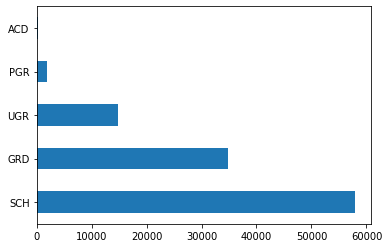

In [16]:
data['education'].value_counts().plot.barh()

Заполним пропуски самым популярным образованием в группе с таким же полом, наличичем машины, регионом, хорошей работой и загран.паспортом.

In [17]:
data['education'] = data.groupby(['sex','car','region_rating','good_work','foreign_passport'], sort=False)['education'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [18]:
#тут заполняю пропуски в Default отрицательным значением, чтобы потом легко понимать что есть что
data.default.fillna(-1, inplace=True)

Посмотрим на категориальные переменные:

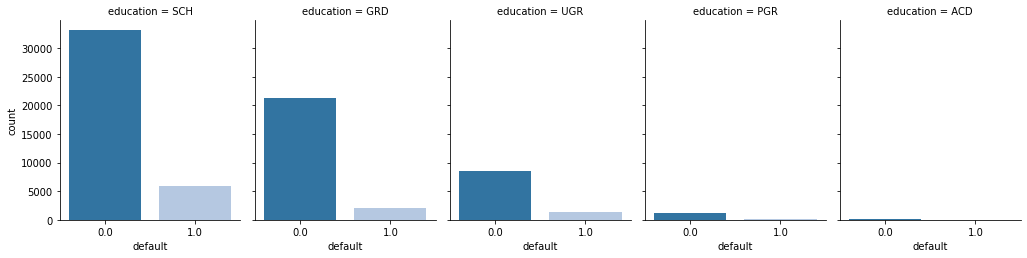

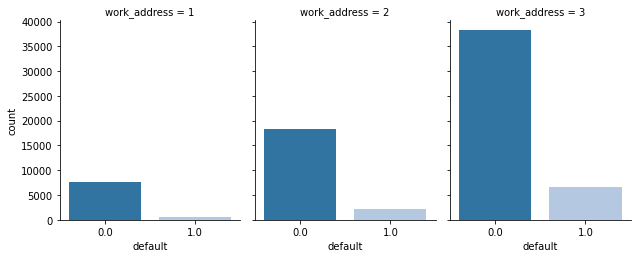

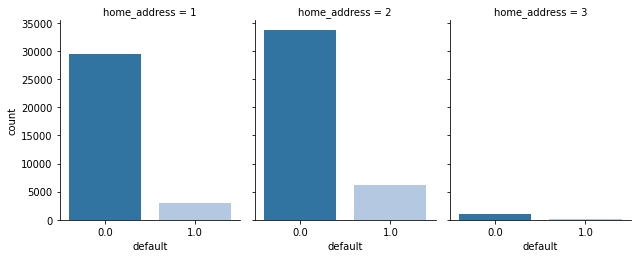

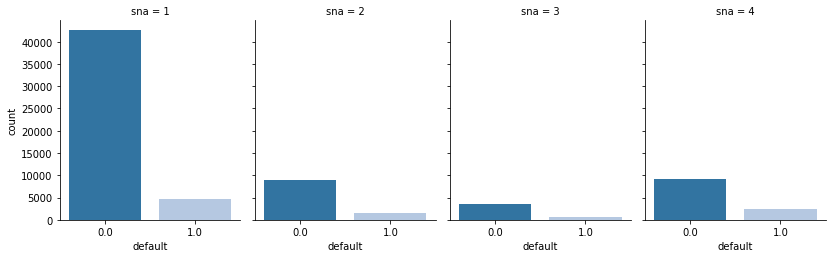

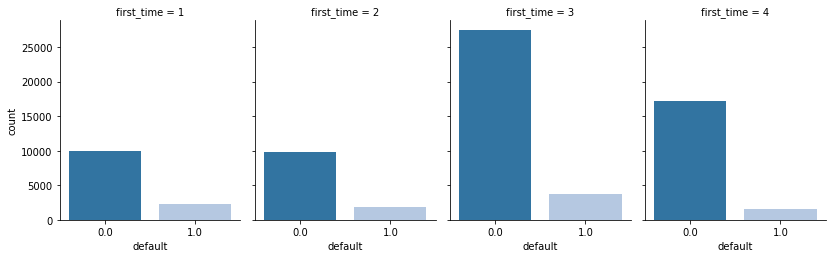

In [26]:
for col in cat_cols:
  get_catplot(col)

SNA = 4, home_address = 2 и first_time = 1 - судя по графикам, скорее всего не вернут кредит.

Людей с образованием ACD и PGR очень мало или они редко берут кредиты. Эти образования, объединим в одну группу.

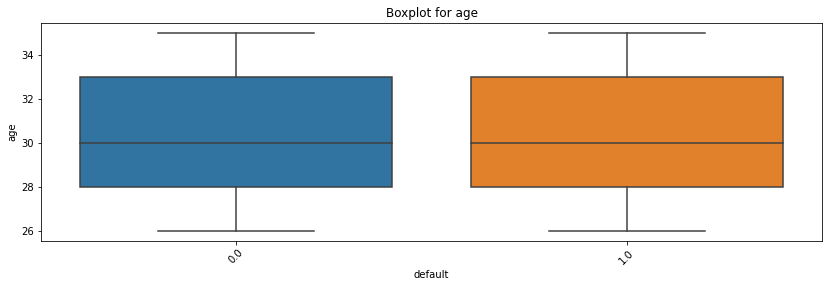

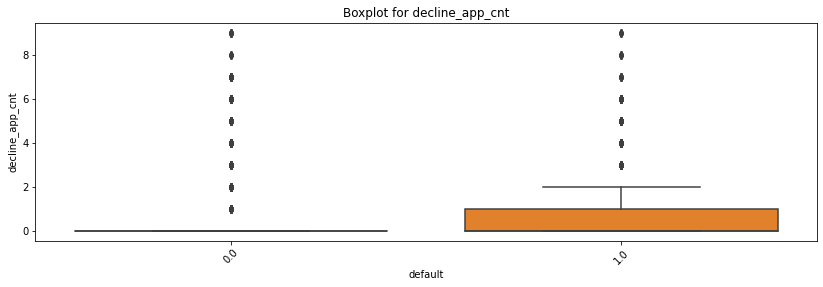

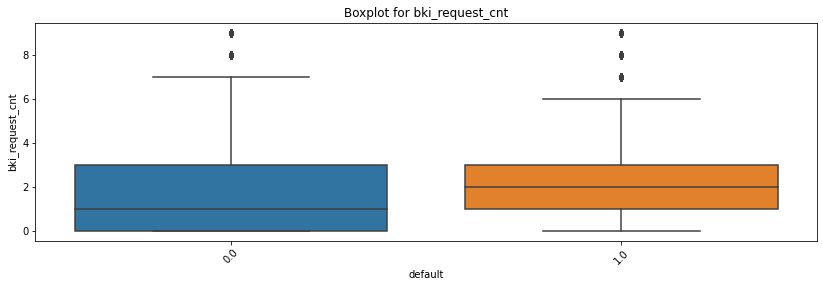

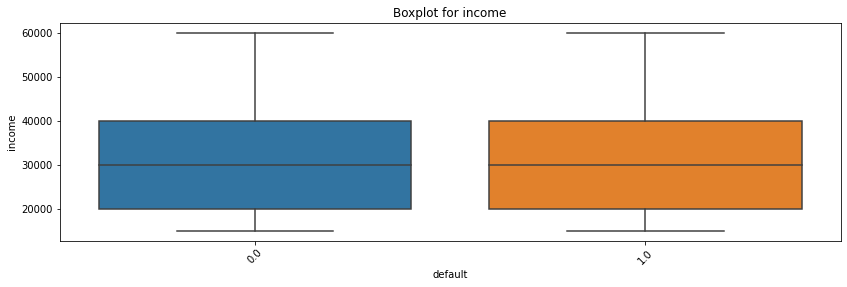

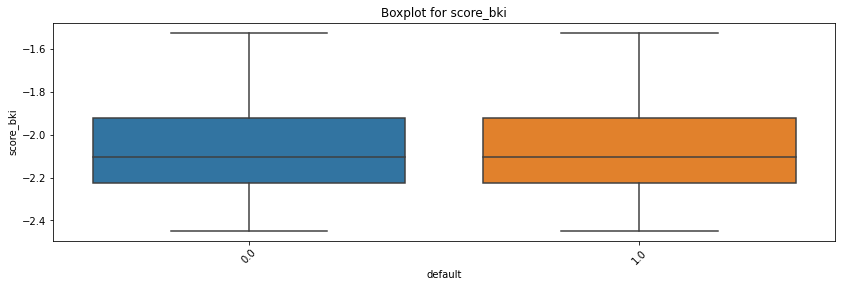

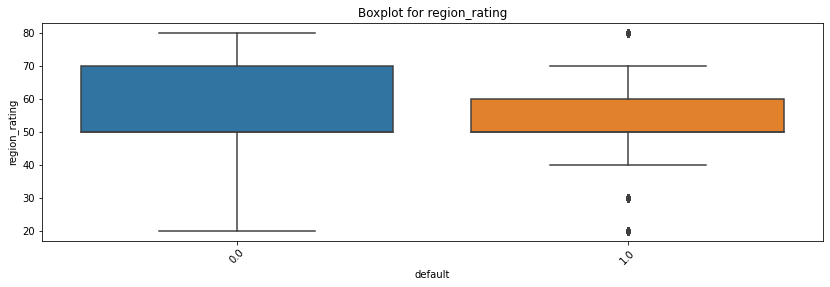

In [27]:
#А что по числовым колонкам?

for col in num_cols:
  get_boxplot(col)

Выводы:
* Если ранее отказывали в кредитах(decline_app_cnt), то есть шанс не возврата.
* 2+ запроса в бюро кредитной истории - плохой звоночек.
* Неплательщики - преимущественно - "средняя полоса"(50-60). Интересно выглядят выбросы где рейтинг 20-30 и default = 1. т.е. не вернувшие кредит там - скорее исключение из правила.

А вот: возвраст, зарплата и score БКИ не влияют на шанс возврата кредита.


Ну и проверим что по распределению числовых переменных

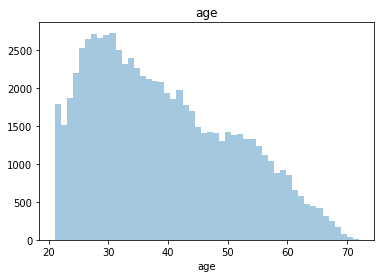

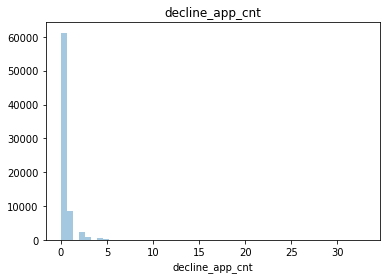

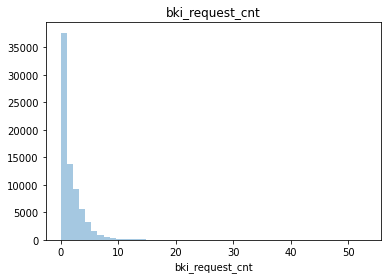

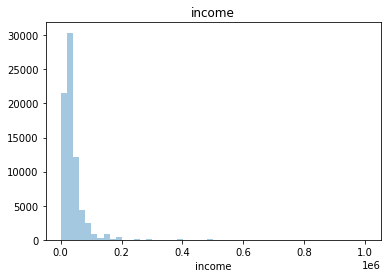

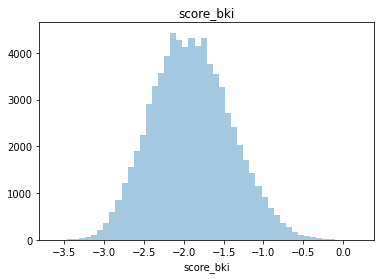

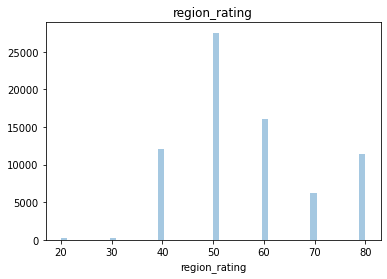

In [31]:
for i in num_cols:
  get_displot(i)

Людей с множеством отказов по кредитам всё таки не так много. 

А распределение людей по регионам объясняет один из предыдущих графиков.

Skore_BKI нужно будет привести к положительному значению чтобы проще логарифмировать.

Займёмся датой

In [33]:
#transform app_date to normal date
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

0        2014-02-01
1        2014-03-12
2        2014-02-01
3        2014-01-23
4        2014-04-18
            ...    
110143   2014-03-31
110144   2014-04-25
110145   2014-03-30
110146   2014-01-07
110147   2014-03-17
Name: app_date, Length: 110148, dtype: datetime64[ns]

In [37]:
#a clean date won't tell us much. Let's try to create a variable - number of days from the date to today.
data['date_diff_today'] = pd.datetime.today() - data.app_date
data['date_diff_today'] = data['date_diff_today'].dt.days
data.drop(['app_date'], axis=1, inplace=True)

data.date_diff_today.max()


2735

# TO DO
Образованием ACD и PGR объединить в одну группу для dummy переменных

score_bki приведем к положительным значениям для упрощения логорифмирования
*data.score_bki = data.score_bki - data.score_bki.min()* 

ИДЕИ для новых фич:

* средняя зарплата по рейтингу региона где живёт человек
* сревнение зарплаты клиента с зарплатой по региону(п1) и признак "хорошая", "средяя", "плохая"(по квартилям?)
* объединить признаки bki_request_cnt и first_time(можно добавить и кол-во отказов в кредитах) data['bki_cnt_first_time'] = data['bki_request_cnt'] * data['first_time']